![EU Banner](images/eu_banner.png)

# **Excursos) Model Initialization Run**
---

This use case intends to introduce the basic mechanics of the hydrological model [LISFLOOD](https://github.com/ec-jrc/lisflood-code/).
<br>
In this exercise, the objective is to conduct a new model initialization run that is much  shorter than the original one of Exercise 2 in order to demonstrate how soil moisture and groundwater storages can differ. <br>
Remember, the initialization run aims to produce the required files of the lower zone average inflow rate:

* **`lzavin.nc`**: a map of the average inflow into the lower groundwater zone.

Instead of producing the **`lzavin.nc`** for the whole run, we just do the Pre Run for 01/01/1975 to 31/01/1975. </br>
As tsaid in Exercise 2, please have a look at [here](https://ec-jrc.github.io/lisflood-code/3_step5_model-initialisation/) for more details. </br>
Basically, we want to see whether the following image holds or not.

![EU Banner](images/image_init.png)

For that, we prepared the 2 corresponding settings files in the **`settings`** folder:

* **`Settings_PreRun_short_init.xml`**: a map of the average inflow into the lower groundwater zone.
* **`Settings_Run_short_init.xml`**: a map of the average inflow into the lower groundwater zone.

Inside the settings of the Pre Run (**`Settings_PreRun_short_init.xml`**) just use the following time infos (or other shortened time infos) and reject any spin-up:

```xml
    ...
    <textvar name="CalendarDayStart" value="02/01/1975 00:00">
    <textvar name="StepStart" value="02/01/1975 00:00">
    <textvar name="StepEnd" value="01/01/1976 00:00">
    <textvar name="NumDaysSpinUp" value="0">
    ...

```
In theory the **`Settings_Run_short_init.xml`** can be left as it is.</br>
Then just navigate to the **`settings`** folder and run after each other via the console:

```bash
conda activate <your_lisflood_environment>
cd <path_where_you_saved_the_repository>/settings/
lisflood Settings_PreRun_short_init.xml
lisflood Settings_Run_short_init.xml
```

As always, read the libraries that we need and use the helper function to read LISFLOOD outputs. 

In [1]:
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
# Universally applicable Lisflood TSS Read Function
def read_lisflood_tss(
    out_dir: Path,
    varname: str,
    run_name: str,
    start_date: str,
    n_gauges: int,
    skiprows: int,
    freq: str = "D"
) -> pd.DataFrame:
    """
    Robust reader for LISFLOOD .tss files with varname+runname convention.
    Handles small float values correctly.
    """
    # run_name = out_dir.name
    tss_file = out_dir / f"{varname}{run_name}.tss"

    if not tss_file.exists():
        print(f"⚠️ Missing LISFLOOD file → filled with NaNs: {tss_file}")
        return pd.DataFrame(
            columns=[f"gauge_{i+1}" for i in range(n_gauges)]
        )

    # Read the file using whitespace delimiter for robustness
    df = pd.read_csv(
        tss_file,
        skiprows=skiprows,
        delim_whitespace=True,
        header=None,
        usecols=range(n_gauges + 1),  # only keep index + gauges
        dtype={i: float for i in range(1, n_gauges + 1)}  # gauge columns as float
    )

    # Only keep the first n_gauges + 1 columns (date/index + gauges)
    df = df.iloc[:, : n_gauges + 1]

    # Convert gauge columns to float safely
    for i in range(1, n_gauges + 1):
        df[i] = df[i].astype(float)

    # Set column names
    df.columns = ["date"] + [f"gauge_{i+1}" for i in range(n_gauges)]

    # Create date index
    df["date"] = pd.date_range(start=start_date, periods=len(df), freq=freq)
    return df.set_index("date")


---

## Excursos a) Lower Zone Averages (lzavin)

We now load the original **`lzavin.nc`** from the **`/initial`** folder and the new one which is created per default in **`/initial/short_init`**. </br>
Afterwards, we willcreate a difference map to see local differences between the two average files.


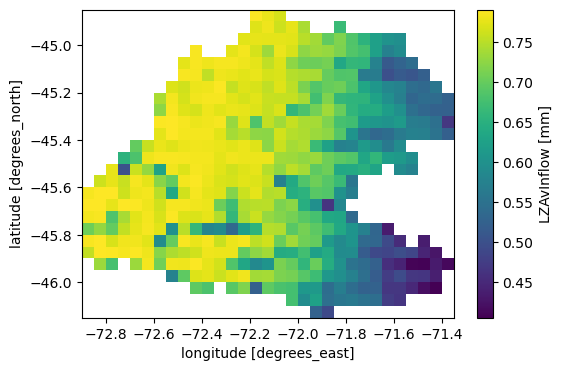

In [3]:
# read and plot the maps
base_fold = Path("..")
initfold = base_fold / "initial"

lzavin_file = "lzavin.nc"

lzavin = xr.open_dataset(initfold / lzavin_file)

# plotting
fig, ax = plt.subplots(figsize=(6,4))
lzavin.lzavin.plot(ax=ax);

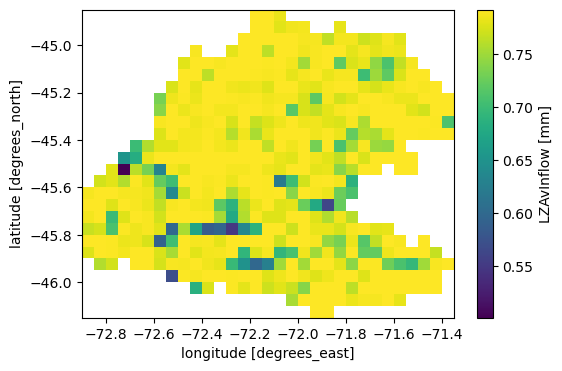

In [4]:
# read and plot the maps
initfold = base_fold / "initial/short_init"
lzavin_file = "lzavin.nc"

lzavin_short = xr.open_dataset(initfold / lzavin_file)

# plotting
fig, ax = plt.subplots(figsize=(6,4))
lzavin_short.lzavin.plot(ax=ax);

Now let us check the differences between both!

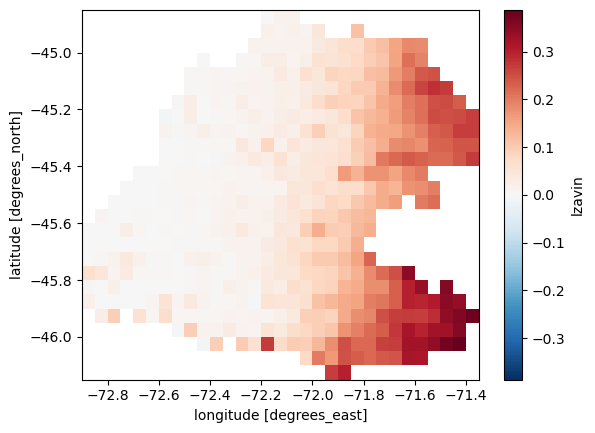

In [5]:
diff = lzavin_short-lzavin
diff.lzavin.plot()

Interestingly, you will likely note the spatial pattern from West to East, with more substantial differences occuring in the Eastern part of the basin. </br>


---
## **Excursos b) State Variables Comparison**
In a next step we will now compare how the five state variables differ at the beginning of the simulation period of the long-term run with the long initialization and the newly created short-term run with only 1 year of initialization. 

The variables we will check are:
* **`Theta1`** (Soil moisture layer 1)
* **`Theta2`**(Soil moisture layer 2)
* **`Theta3`**(Soil moisture layer 3)
* **`UZ`** (Storage upper zone)
* **`LZ`** (Storage lower zone)

In [6]:
# Read Simulated Q Data
run_name = "long_term_run"
DIS_FILE = base_fold / f"out/{run_name}/dis{run_name}.tss"
out_fold = base_fold / "out/{run_name}"

with open(DIS_FILE) as f:
    lines = f.readlines()

# Extract number of gauges
n_gauges = int(lines[1].strip()) - 1
skiprows = 3 + n_gauges

# Read Sim (all Vars)
var = "lzUps"
var2 = "uzUps"
var3 = "theta1total"
var4 = "theta2total"
var5 = "theta3total"

# Load also long-term run simulation from before
STEP_START = "01/02/1975 00:00" 

outfold = base_fold / "out/long_term_run/"
lz_original = read_lisflood_tss(
            outfold, var, run_name, STEP_START, n_gauges, skiprows
        )
uz_original = read_lisflood_tss(
            outfold, var2, run_name, STEP_START, n_gauges, skiprows
        )

theta_original = read_lisflood_tss(
            outfold, var3, run_name, STEP_START, n_gauges, skiprows
        )

theta2_original = read_lisflood_tss(
            outfold, var4, run_name, STEP_START, n_gauges, skiprows
        )

theta3_original = read_lisflood_tss(
            outfold, var5, run_name, STEP_START, n_gauges, skiprows
        )

# Load also long-term run simulation from before
outfold_short = base_fold / "out/short_init"
lz_short = read_lisflood_tss(
            outfold_short, var, run_name, STEP_START, n_gauges, skiprows
        )
uz_short = read_lisflood_tss(
            outfold_short, var2, run_name, STEP_START, n_gauges, skiprows
        )

theta_short = read_lisflood_tss(
            outfold_short, var3, run_name, STEP_START, n_gauges, skiprows
        )

theta2_short = read_lisflood_tss(
            outfold_short, var4, run_name, STEP_START, n_gauges, skiprows
        )

theta3_short = read_lisflood_tss(
            outfold_short, var5, run_name, STEP_START, n_gauges, skiprows
        )

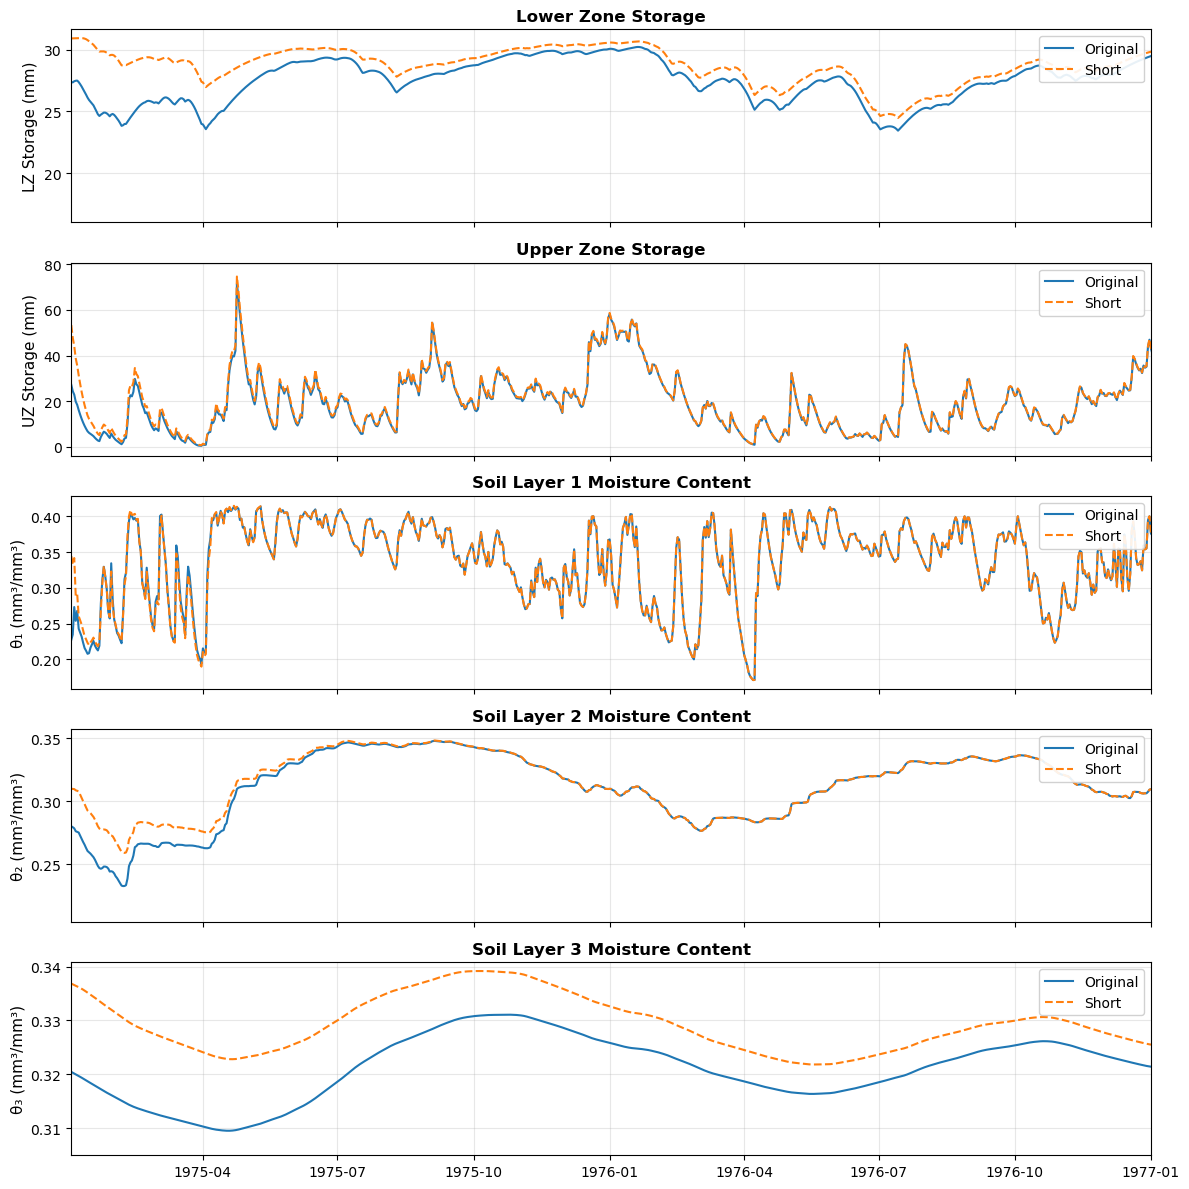

In [7]:
# Create figure with 5 subplots (5 rows, 1 column for vertical comparison)
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

# Define common x-axis limit (first year: 365 days)
xlim = (lz_short.index[0], lz_short.index[365*2])

# Subplot 1: Lower Zone Storage (lz)
ax1 = axes[0]
ax1.plot(lz_original.index, lz_original.values, label='Original', color='tab:blue', linewidth=1.5)
ax1.plot(lz_short.index, lz_short.values, label='Short', color='tab:orange', linewidth=1.5, linestyle='--')
ax1.set_ylabel('LZ Storage (mm)', fontsize=11)
ax1.set_title('Lower Zone Storage', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(xlim)

# Subplot 2: Upper Zone Storage (uz)
ax2 = axes[1]
ax2.plot(uz_original.index, uz_original.values, label='Original', color='tab:blue', linewidth=1.5)
ax2.plot(uz_short.index, uz_short.values, label='Short', color='tab:orange', linewidth=1.5, linestyle='--')
ax2.set_ylabel('UZ Storage (mm)', fontsize=11)
ax2.set_title('Upper Zone Storage', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(xlim)

# Subplot 3: Soil Layer 1 Moisture Content (theta)
ax3 = axes[2]
ax3.plot(theta_original.index, theta_original.values, label='Original', color='tab:blue', linewidth=1.5)
ax3.plot(theta_short.index, theta_short.values, label='Short', color='tab:orange', linewidth=1.5, linestyle='--')
ax3.set_ylabel('θ₁ (mm³/mm³)', fontsize=11)
ax3.set_title('Soil Layer 1 Moisture Content', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(xlim)

# Subplot 4: Soil Layer 2 Moisture Content (theta2)
ax4 = axes[3]
ax4.plot(theta2_original.index, theta2_original.values, label='Original', color='tab:blue', linewidth=1.5)
ax4.plot(theta2_short.index, theta2_short.values, label='Short', color='tab:orange', linewidth=1.5, linestyle='--')
ax4.set_ylabel('θ₂ (mm³/mm³)', fontsize=11)
ax4.set_title('Soil Layer 2 Moisture Content', fontsize=12, fontweight='bold')
ax4.legend(loc='upper right', framealpha=0.9)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(xlim)

# Subplot 5: Soil Layer 3 Moisture Content (theta3)
ax5 = axes[4]
ax5.plot(theta3_original.index, theta3_original.values, label='Original', color='tab:blue', linewidth=1.5)
ax5.plot(theta3_short.index, theta3_short.values, label='Short', color='tab:orange', linewidth=1.5, linestyle='--')
ax5.set_ylabel('θ₃ (mm³/mm³)', fontsize=11)
ax5.set_title('Soil Layer 3 Moisture Content', fontsize=12, fontweight='bold')
ax5.legend(loc='upper right', framealpha=0.9)
ax5.grid(True, alpha=0.3)
ax5.set_xlim(xlim)

plt.tight_layout()




While the soil moisture of layer 1 does not differ as much as on the original image shown in the introduction section of this notebook, we can see notable differences for the soil moisture of layer 2 and layer 3, but also for the upper and (particularly) the lower zone storage! It becomes obvious that even after 3 years some of the state variables did not reach steady state conditions! 